# COS-method

We offer you the following practical task on the COS-method. 

Total score is **110**, which will be converted to $22\%$ of the course grade. You have $1$ month for this work. **Deadline is the 30st of December, 23:59 MSK**.

The file must be sent to **stoch-vol-23-fall@yandex.ru** with topic "stoch-vol Lab2".  Please rename your file as **"SurnameName_Lab2.ipynb"** before sending. 

If you have any questions feel free to ask in Telegram in the **group chat**.

**Full name:**

**Faculty:**

In [280]:
from copy import deepcopy
from typing import Callable, Union
import math
from dataclasses import dataclass, replace, is_dataclass

import numpy as np
import numpy.typing as npt
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from py_vollib.black_scholes.implied_volatility import implied_volatility

In [281]:
implied_volatility_vec = np.vectorize(implied_volatility)

In [356]:
ZONE              = ZoneInfo("Europe/Moscow")
ASSIGNMENT_DT     = datetime(2023, 12, 2, 23, 45, 0, tzinfo=ZONE)
NO_PENALTY_PERIOD = timedelta(days=14)
HARD_DEADLINE     = datetime(2023, 12, 30, 23, 59, 59, tzinfo=ZONE)

In [357]:
def get_score_multiplier(lab_hand_dt: datetime = datetime.now().astimezone()) -> float:
    """Calculate overeall lab score multiplier.
    
    The function calculates the lab score weighting factor, based on time,
    when the solved lab was handed in. The factor equals 1 during the 
    `NO_PENALTY_PERIOD` starting at the `ASSIGNMENT_DT, then lineary decays
    towards 0 by the `HARD_DEADLINE`date.
    
    Args:
        lab_hand_dt: datetime when the lab is handed in. Now by default. Must be
        timezone-aware.
    
    Returns:
        A factor between 0 and 1, by which the final score will be multiplied.
    """
    assert lab_hand_dt.tzinfo is not None,\
        "The argument must be timezone-aware. Use `datetime.astimezone()` "\
        "to use your local timezone."
    
    if lab_hand_dt < ASSIGNMENT_DT + NO_PENALTY_PERIOD:
        return 1.
    
    decay_period = HARD_DEADLINE - ASSIGNMENT_DT - NO_PENALTY_PERIOD
    elapsed_with_penalty = lab_hand_dt - ASSIGNMENT_DT - NO_PENALTY_PERIOD
    factor = 1. - elapsed_with_penalty.total_seconds() / decay_period.total_seconds()
    return max(0., factor)

In [ ]:
HAND_IN_DT = ...
LAB_SCORE = ...
print(f"Final score is {int(LAB_SCORE * get_score_multiplier(HAND_IN_DT))}")

# Episode 1: pricing with COS-method (50 points)

In [342]:
FloatArray = npt.NDArray[np.float_]
Floats = Union[float, FloatArray]

@dataclass
class MarketState:
    stock_price: Floats
    interest_rate: Floats
    time: Floats = 0

@dataclass
class HestonParams:
    v: float # initial variance V_0
    kappa: float # speed of mean-reversion 
    theta: float # long-term mean
    sigma: float # vol of vol
    rho: float # correlation between brownian motions
    
@dataclass
class StockOption:
    strike_price: Floats
    expiration_time: Floats  # in years
    is_call: Union[bool, npt.NDArray[np.bool_]] = None
    
    def __post_init__(self):
        assert self.is_call is not None
    
    def payoff(self, stock_price: Floats) -> Floats:
        call_payoff = np.maximum(0, stock_price - self.strike_price)
        put_payoff = np.maximum(0, self.strike_price - stock_price)
        return np.where(self.is_call, call_payoff, put_payoff)

class CallStockOption(StockOption):
    def __post_init__(self):
        self.is_call = True
        
class PutStockOption(StockOption):
    def __post_init__(self):
        self.is_call = False

In [343]:
def heston_log_char_func(omega: Floats,
                         dt: Floats,
                         p: HestonParams) -> Floats:
    """Computes the logarithm og the Heston characteristic function assuming the stock
    trades at 1 and no drift.

    To recover the CF if the stock trades at s multiply by the factor
    exp(i omega (log(s) + \mu dt)) the exponent of the result.

    Args:
        omega: frequency dual to the price domain
        dt: time to evaluate CF at
        p: model parameters

    Returns:
        float: log characteristic function value
    """
    D = np.sqrt(
        (p.kappa - 1j * p.rho * p.sigma * omega) ** 2
        + (omega ** 2 + 1j * omega) * p.sigma ** 2
    )
    F = p.kappa - 1j * p.rho * p.sigma * omega - D
    G = F / (F + 2 * D)
    df = np.exp(-D * dt)  # discount factor
    return (
        p.v / p.sigma ** 2 * (1 - df) / (1 - G * df) * F
        + p.kappa * p.theta / p.sigma ** 2 * (
            dt * F - 2 * np.log((1 - G * df) / (1 - G))
        )
    )

## Implement coefficients for vanilla put

In [109]:
def vanilla_put_cos_expansion_coeffs(a: Floats,
                                     b: Floats,
                                     k: int) -> Floats:
    """
    Computes the cosine expansion coefficients of the vanilla put option
    payoff.

    Args:
        a, b: integration bounds for the payoff function
        k: number of coefficients

    Returns:
        vector of coefficients
    """
    assert np.shape(a) == np.shape(b)

    raise NotImplemented
    
    assert np.shape(res) == (*np.shape(a), k)  # hint for proper vectorization
    return res

## Implement the COS method

For now use the following stub to calculate the truncation range

In [346]:
def calc_trunc_range(eps: float, params: HestonParams, dt: float):
    return np.array(300.)

In [347]:
def price(
    option: StockOption,
    ms: MarketState,
    params: HestonParams,
    eps: float = 1e-3,
    n_points: int = 4096,
):
    dt = np.asarray(option.expiration_time - ms.time)
    trunc_range = calc_trunc_range(eps, params, dt)

    # don't forget to check the argument to be within the truncation bounds
    
    # assure that the resulting option price strictly greater than the theoretical
    # price lower bound
    
    raise NotImplemented

In [348]:
strikes = np.linspace(40, 200, 15)
time = np.array(1.0)

calls = CallStockOption(strike_price=strikes,
                        expiration_time=time)
puts = PutStockOption(strike_price=strikes,
                      expiration_time=time)

ms = MarketState(stock_price=100, interest_rate=0.05)

params = HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.7, rho=-0.2)

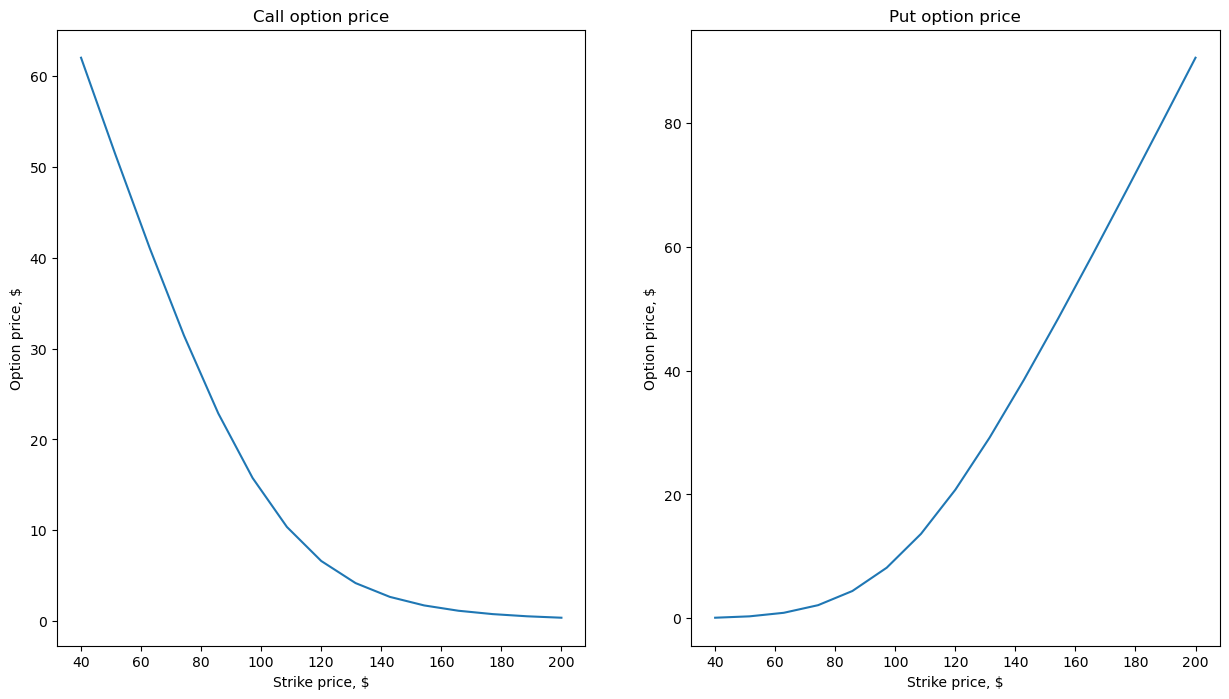

In [349]:
call_price = price(calls, ms, params)
put_price = price(puts, ms, params)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))

ax1.plot(strikes, call_price)
ax1.set_title('Call option price')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Option price, $')

ax2.plot(strikes, put_price)
ax2.set_title('Put option price')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Option price, $')

plt.show()

# Episode 2: checking with MC (30 points)

implement the `price_mc` function and check the correctness of the imlementation.

In [352]:
def price_mc(
    option: StockOption,
    ms: MarketState,
    params: HestonParams,
    n_points: int,
):
    # you can copy-paste code from seminars, but check it for correctness :)
    raise NotImplemented

In [353]:
strikes = np.linspace(70, 140, 16)
time = np.array(1.0)

calls = CallStockOption(strike_price=strikes,
                        expiration_time=time)
puts = PutStockOption(strike_price=strikes,
                      expiration_time=time)

ms = MarketState(stock_price=100, interest_rate=0.1)

params = HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.7, rho=-0.2)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

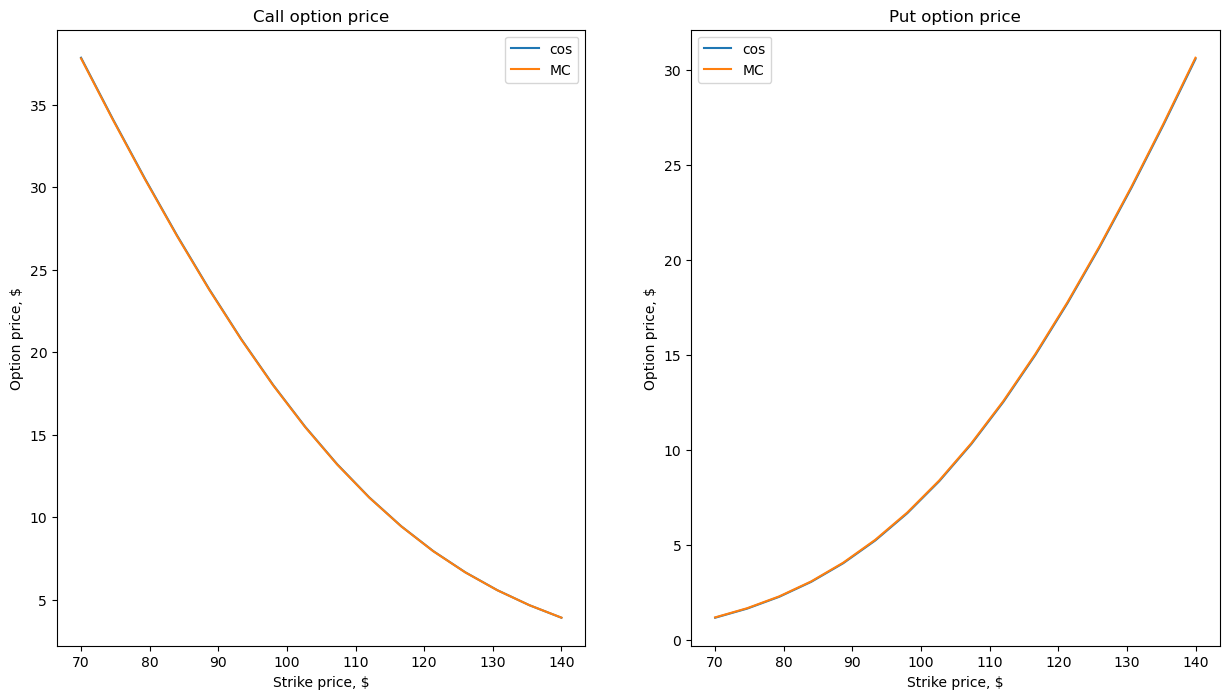

In [339]:
call_price_mc = price_mc(calls, ms, params, 100000)
put_price_mc = price_mc(puts, ms, params, 100000)
call_price = price(calls, ms, params)
put_price = price(puts, ms, params)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))

ax1.plot(strikes, call_price, label="cos")
ax1.plot(strikes, call_price_mc, label="MC")
ax1.set_title('Call option price')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Option price, $')
ax1.legend()

ax2.plot(strikes, put_price, label="cos")
ax2.plot(strikes, put_price_mc, label="MC")
ax2.set_title('Put option price')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Option price, $')
ax2.legend()

plt.show()

In [340]:
def iv(option: StockOption, ms: MarketState, price: Floats):
    assert isinstance(option, (CallStockOption, PutStockOption))
    
    flag = "c" if isinstance(option, CallStockOption) else "p"
    return implied_volatility_vec(
        price=price,
        S=ms.stock_price,
        K=option.strike_price,
        t=option.expiration_time - ms.time,
        r=ms.interest_rate,
        flag=flag,
    )

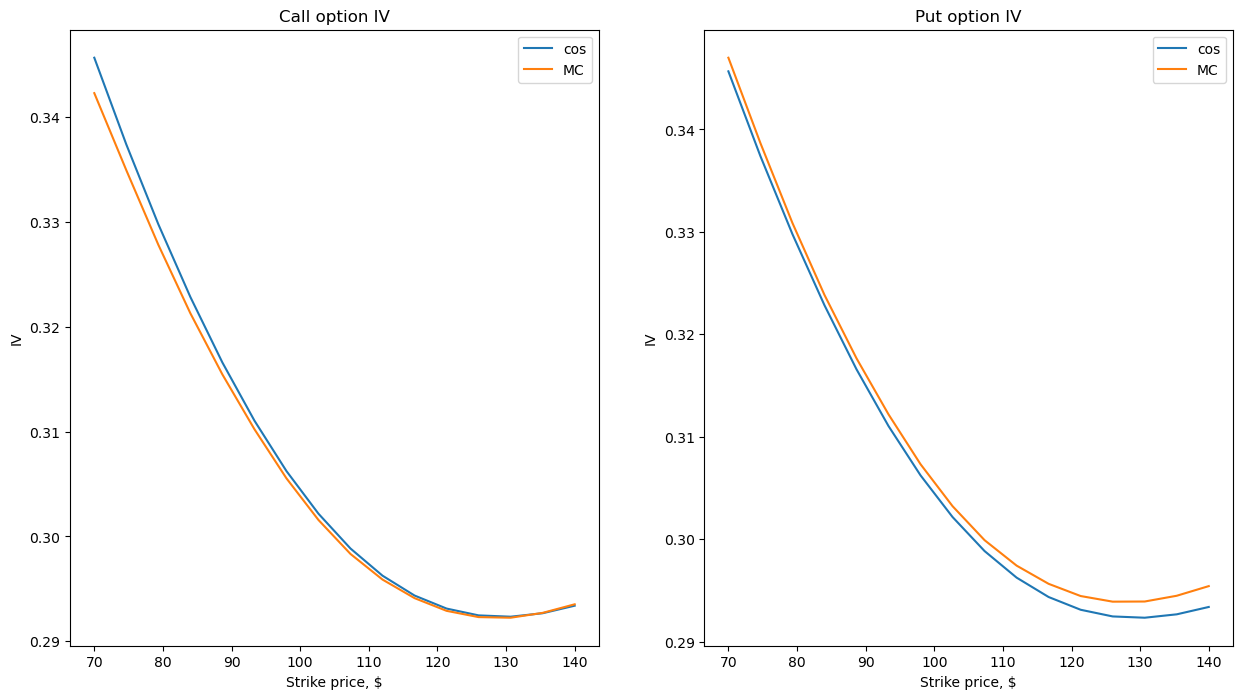

In [341]:
call_iv_mc = iv(calls, ms, call_price_mc)
put_iv_mc = iv(puts, ms, put_price_mc)
call_iv = iv(calls, ms, call_price)
put_iv = iv(puts, ms, put_price)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))

ax1.plot(strikes, call_iv, label="cos")
ax1.plot(strikes, call_iv_mc, label="MC")
ax1.set_title('Call option IV')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('IV')
ax1.legend()

ax2.plot(strikes, put_iv, label="cos")
ax2.plot(strikes, put_iv_mc, label="MC")
ax2.set_title('Put option IV')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('IV')
ax2.legend()

plt.show()

# Episode 3: the truncatoin range (20 points)

Implement the truncation range choosing algorithm from one of the following papers:
1. [Original paper](https://mpra.ub.uni-muenchen.de/9319/1/MPRA_paper_9319.pdf)
1. [Markov's inequality based](https://www.sciencedirect.com/science/article/pii/S0096300322000212/pdfft?md5=b288c9e0da77d57a61e5a496dffde778&pid=1-s2.0-S0096300322000212-main.pdf)

Use whatever you want: analytical solution, automatic differentiation, automatic code generation, even rust.
Have fun!

# Episode 4: Memes (10 points) 🤡

Come up with a funny financial math meme.
If the meme is not funny, then we will have to deduct points.
Don't steal memes, come up with your own!